Part 1

In [34]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt, seaborn as sns
from torchsummary import summary
from PIL import Image
from captum.attr import LayerGradCam, LayerAttribution, visualization as viz
from captum.attr import Occlusion
import random
import torch.multiprocessing as mp
import numpy as np

In [6]:
# Load full split and create indices
dataset = load_dataset("pantelism/cats-vs-dogs")["train"]
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

# Shuffle indices for random split
shuffled_indices = torch.randperm(total_size).tolist()
train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:train_size + val_size]
test_indices = shuffled_indices[train_size + val_size:]

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

eval_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class HFImgDS(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, indices, transform):
        self.dataset = hf_dataset
        self.indices = indices
        self.transform = transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        example = self.dataset[self.indices[idx]]
        image = example["image"]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        x = self.transform(image.convert("RGB"))
        y = torch.tensor(example["label"], dtype=torch.long)
        return x, y


train_dataset = HFImgDS(dataset, train_indices, train_transform)
val_dataset = HFImgDS(dataset, val_indices, eval_transform)
test_dataset = HFImgDS(dataset, test_indices, eval_transform)

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 2)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gap(x).flatten(1)
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
input_shape = (3, 96, 96)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
         MaxPool2d-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          18,496
         MaxPool2d-4           [-1, 64, 24, 24]               0
 AdaptiveAvgPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                    [-1, 2]             130
Total params: 19,522
Trainable params: 19,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 4.22
Params size (MB): 0.07
Estimated Total Size (MB): 4.40
----------------------------------------------------------------


In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 5

# Train
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)  

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            val_running_loss += criterion(out, y).item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    
    val_loss.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / val_total)
    
    print(f"Epoch {epoch+1}: TrainAcc={train_acc[-1]:.3f} ValAcc={val_acc[-1]:.3f}")

Epoch 1: TrainAcc=0.560 ValAcc=0.568
Epoch 2: TrainAcc=0.586 ValAcc=0.623
Epoch 3: TrainAcc=0.598 ValAcc=0.623
Epoch 4: TrainAcc=0.607 ValAcc=0.620
Epoch 5: TrainAcc=0.615 ValAcc=0.527


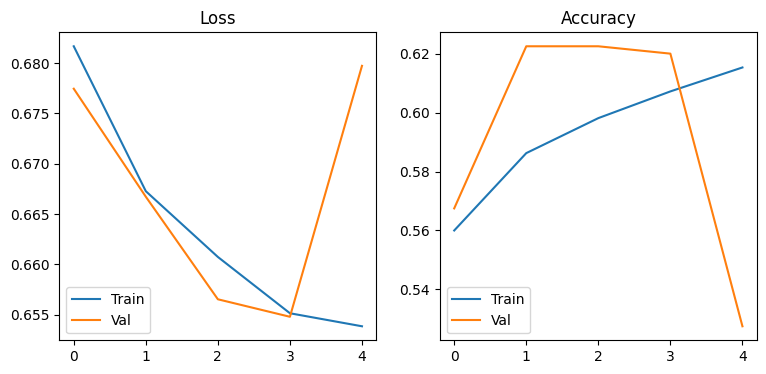

In [41]:
# Loss & Accuracy plots
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title('Accuracy')
plt.legend()

plt.show()

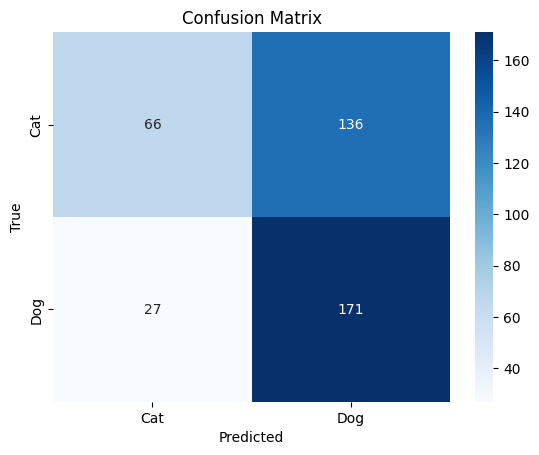

              precision    recall  f1-score   support

         Cat       0.71      0.33      0.45       202
         Dog       0.56      0.86      0.68       198

    accuracy                           0.59       400
   macro avg       0.63      0.60      0.56       400
weighted avg       0.63      0.59      0.56       400



In [12]:
# Confusion matrix & classification report
model.eval()
actual_labels = []
predicted_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        predictions = model(X).argmax(1)
        actual_labels.extend(y.cpu().tolist())
        predicted_labels.extend(predictions.cpu().tolist())

class_names = ['Cat', 'Dog']
sns.heatmap(
    confusion_matrix(actual_labels, predicted_labels),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(actual_labels, predicted_labels, target_names=class_names))

Part 2

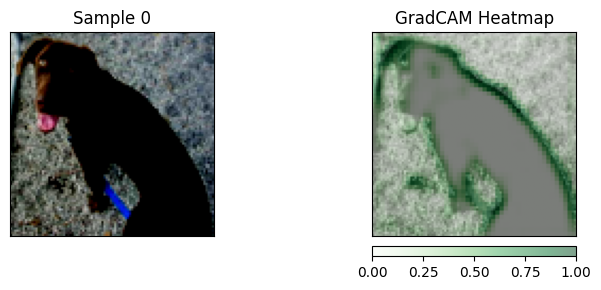

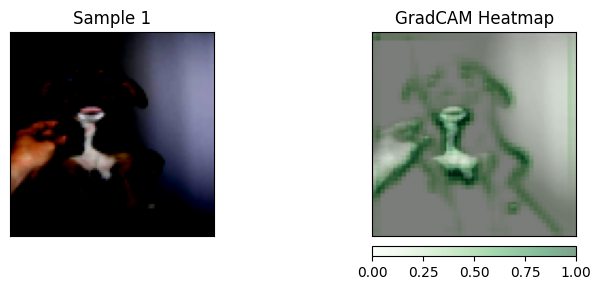

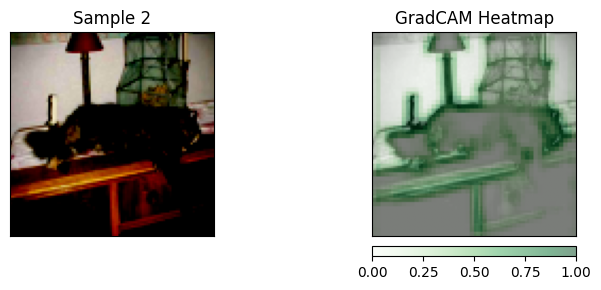

In [26]:
model.eval()
target_layer = model.conv2

sample_indices = [0, 1, 2]

def get_img_tensor(idx):
    img, _ = test_dataset[idx]
    img_input = img.unsqueeze(0).to(device)
    return img_input

for sample_idx in sample_indices:
    img_input = get_img_tensor(sample_idx)
    with torch.no_grad():
        predicted_class = model(img_input).argmax(1).item()
        
    gradcam = LayerGradCam(model, target_layer)
    attribution = gradcam.attribute(img_input, target=predicted_class)
    upsampled_attr = LayerAttribution.interpolate(attribution, img_input.shape[2:])
    original_img = img_input[0].cpu().permute(1, 2, 0).detach().numpy()
    heatmap = upsampled_attr[0].cpu().permute(1, 2, 0).detach().numpy()
    
    viz.visualize_image_attr_multiple(
        heatmap,
        original_img,
        ["original_image", "blended_heat_map"],
        ["all", "positive"],
        show_colorbar=True,
        titles=[f"Sample {sample_idx}", "GradCAM Heatmap"],
        fig_size=(8, 3)
    )

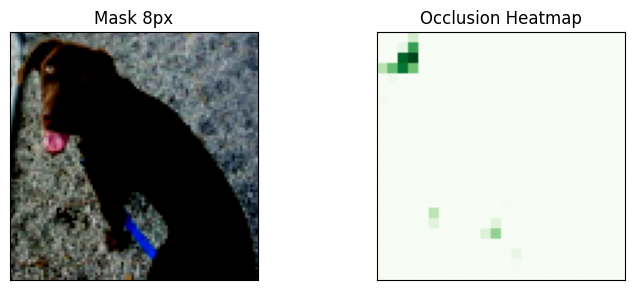

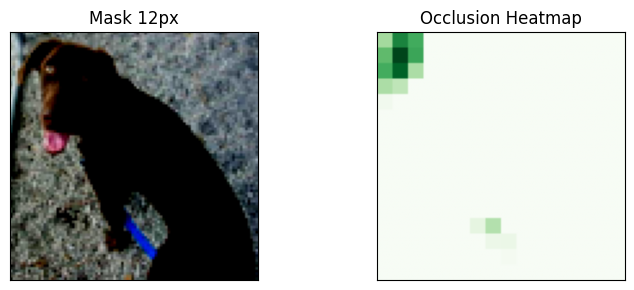

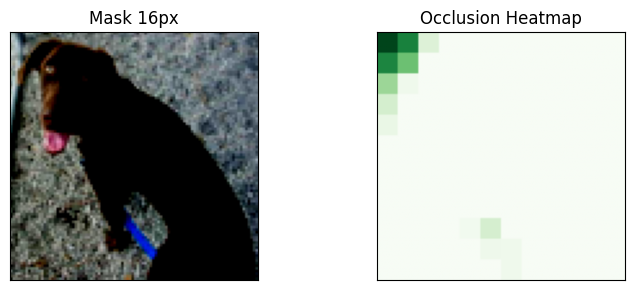

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Mask 8px: Accuracy: 0.595
Mask 12px: Accuracy: 0.585
Mask 16px: Accuracy: 0.585


In [32]:
occ = Occlusion(model)
window_sizes = [8, 12, 16]

img, _ = test_dataset[0]
img_input = img.unsqueeze(0).to(device)
predicted_class = model(img_input).argmax(1).item()

for window_size in window_sizes:
    attribution = occ.attribute(
        img_input,
        target=predicted_class,
        sliding_window_shapes=(3, window_size, window_size),
        strides=(3, window_size//2, window_size//2),
        baselines=0
    )
    
    original_img = img_input[0].cpu().permute(1, 2, 0).detach().numpy()
    heatmap = attribution[0].cpu().permute(1, 2, 0).detach().numpy()
    
    viz.visualize_image_attr_multiple(
        heatmap,
        original_img,
        ["original_image", "heat_map"],
        ["all", "positive"],
        titles=[f"Mask {window_size}px", "Occlusion Heatmap"],
        fig_size=(8, 3)
    )
    
# Measure accuracy for each mask
def random_mask(X, mask_size):
    X = X.clone()
    batch_size, channels, height, width = X.shape
    for idx in range(batch_size):
        start_h = random.randint(0, height - mask_size)
        start_w = random.randint(0, width - mask_size)
        X[idx, :, start_h:start_h+mask_size, start_w:start_w+mask_size] = 0
    return X

def occlusion_accuracy(loader, mask_size):
    num_correct = 0
    num_total = 0
    loader.num_workers = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            X_masked = random_mask(X, mask_size)
            preds = model(X_masked).argmax(1)
            num_correct += (preds == y).sum().item()
            num_total += y.size(0)
    return num_correct / num_total

for window_size in window_sizes:
    accuracy = occlusion_accuracy(test_loader, window_size)
    print(f"Mask {window_size}px: Accuracy: {accuracy:.3f}")

Part 3

Epsilon=0.010: Accuracy on adversarial examples: 0.527
Epsilon=0.030: Accuracy on adversarial examples: 0.400
Epsilon=0.100: Accuracy on adversarial examples: 0.367


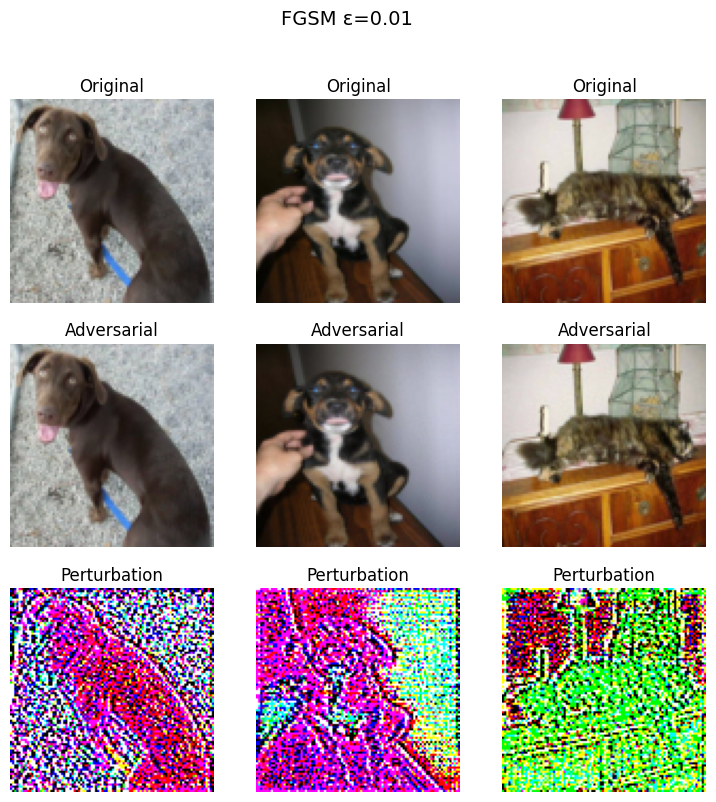

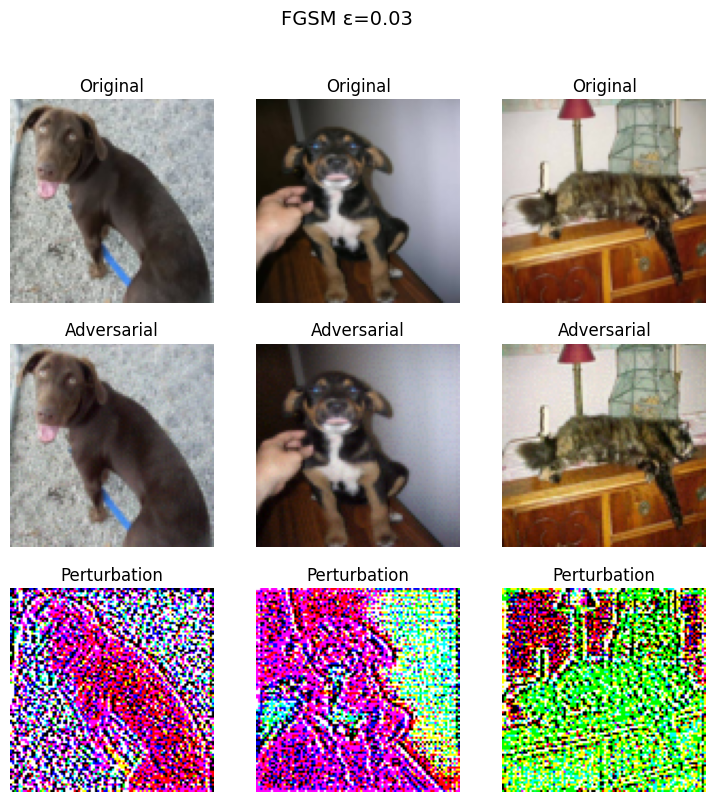

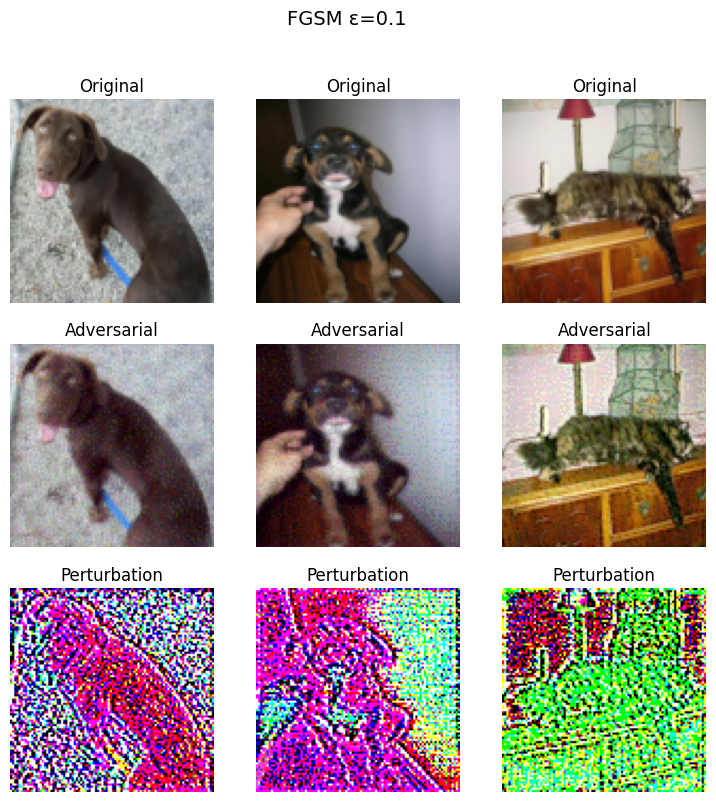

In [42]:
epsilon_values = [0.01, 0.03, 0.1]


def denorm_batch(tensor):
    tensor = tensor.detach().cpu().permute(0, 2, 3, 1).numpy()
    tensor = (tensor * 0.5) + 0.5
    return np.clip(tensor, 0, 1)
def fgsm_step(input_tensor, epsilon):
    grad = input_tensor.grad.data
    adversarial = input_tensor + epsilon * grad.sign()
    return adversarial.clamp(-1.0, 1.0)
def eval_fgsm(loader, epsilon, num_samples=3):
    model.eval()
    num_correct = 0
    num_total = 0
    saved_examples = []
    collected = False
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        X.requires_grad = True
        logits = model(X)
        loss = F.cross_entropy(logits, y)
        model.zero_grad()
        if X.grad is not None:
            X.grad.zero_()
        
        loss.backward()
        X_adv = fgsm_step(X, epsilon)
        with torch.no_grad():
            preds = model(X_adv).argmax(1)
            num_correct += (preds == y).sum().item()
            num_total += y.size(0)
        
        if not collected:
            orig_batch = denorm_batch(X[:num_samples])
            adv_batch = denorm_batch(X_adv[:num_samples])
            pert_batch = adv_batch - orig_batch
            for i in range(min(num_samples, X.shape[0])):
                saved_examples.append((orig_batch[i], adv_batch[i], pert_batch[i]))
            collected = True
    return num_correct / num_total, saved_examples

# Run attack on different epsilon values
attack_results = {}

for epsilon in epsilon_values:
    accuracy, examples = eval_fgsm(test_loader, epsilon, num_samples=3)
    attack_results[epsilon] = {"accuracy": accuracy, "examples": examples}
    print(f"Epsilon={epsilon:.3f}: Accuracy on adversarial examples: {accuracy:.3f}")

# See the results
for epsilon in epsilon_values:
    examples = attack_results[epsilon]["examples"]
    
    if not examples:
        continue
    num_cols = len(examples)
    fig, axes = plt.subplots(3, num_cols, figsize=(3*num_cols, 9))
    fig.suptitle(f'FGSM ε={epsilon}', fontsize=14)
    for col_idx, (original, adversarial, perturbation) in enumerate(examples):
        axes[0, col_idx].imshow(original)
        axes[0, col_idx].axis('off')
        axes[0, col_idx].set_title('Original')
        axes[1, col_idx].imshow(adversarial)
        axes[1, col_idx].axis('off')
        axes[1, col_idx].set_title('Adversarial')
        vmax = np.max(np.abs(perturbation))
        pert_vis = (perturbation / (2 * vmax) + 0.5) if vmax != 0 else perturbation
        axes[2, col_idx].imshow(np.clip(pert_vis, 0, 1))
        axes[2, col_idx].axis('off')
        axes[2, col_idx].set_title('Perturbation')
    
    plt.show()

Part 4

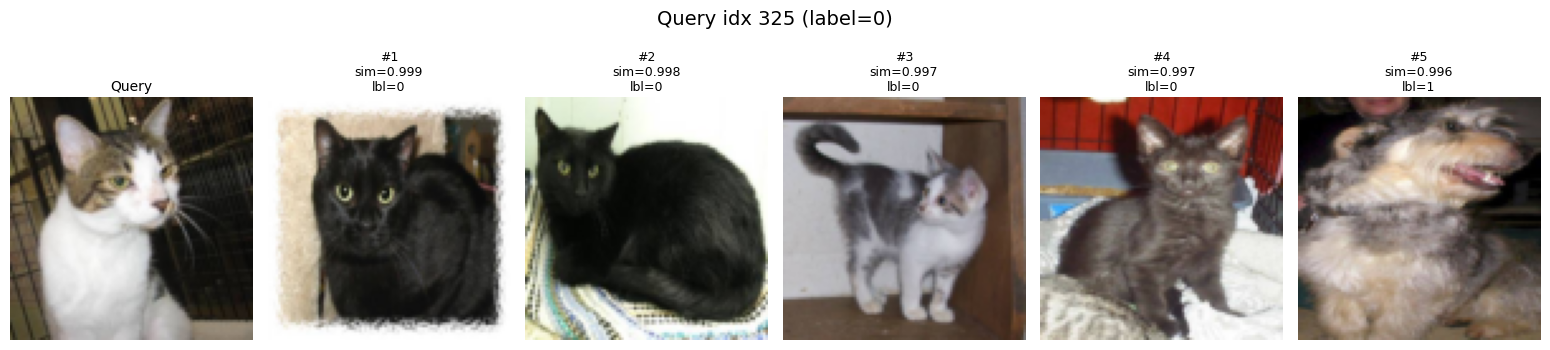

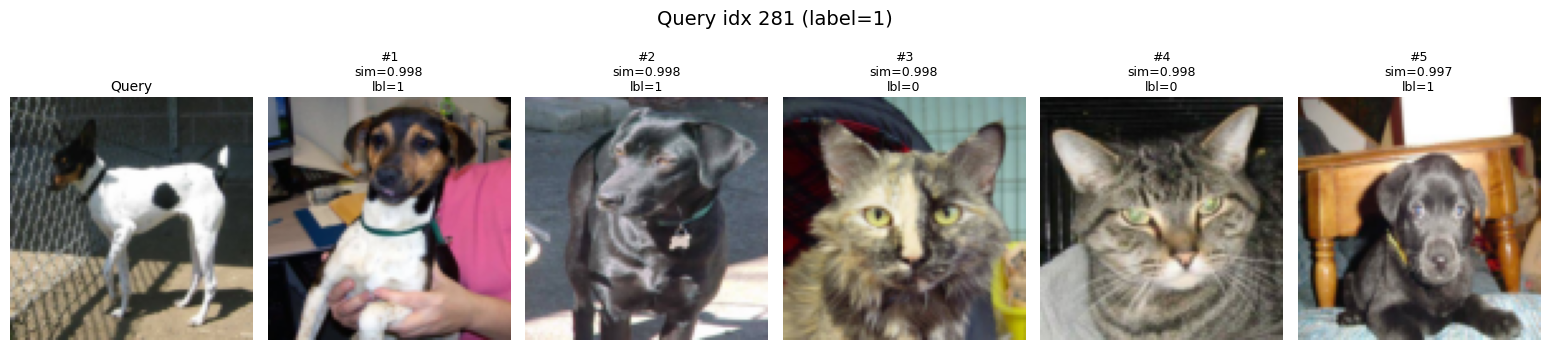

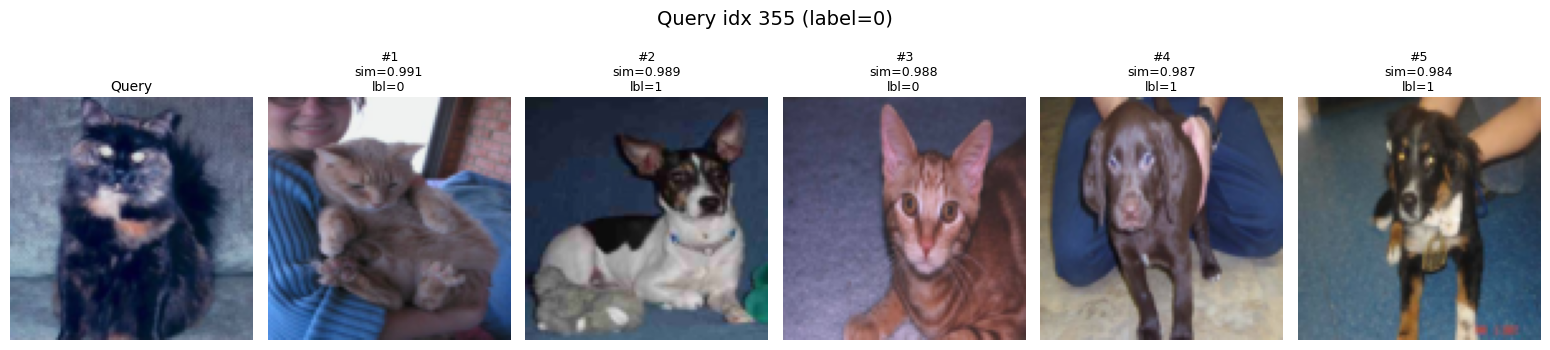

In [39]:
top_k = 5
num_queries = 3

model.eval()
feature_vectors = []
image_list = []
label_list = []

# Extract features from set
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        conv1_out = model.pool(F.relu(model.conv1(X)))
        conv2_out = model.pool(F.relu(model.conv2(conv1_out)))
        features = model.gap(conv2_out).flatten(1)
        feature_vectors.append(features.cpu())
        denormed = ((X.cpu().permute(0, 2, 3, 1).numpy() * 0.5) + 0.5).tolist()
        image_list.extend(denormed)
        label_list.extend(y.cpu().tolist())

feature_vectors = torch.cat(feature_vectors, 0)
feature_vectors = feature_vectors / (feature_vectors.norm(dim=1, keepdim=True) + 1e-10)
total_samples = feature_vectors.shape[0]
query_indices = random.sample(range(total_samples), num_queries)

# Find and display similar images
for query_idx in query_indices:
    query_vector = feature_vectors[query_idx].unsqueeze(0)
    similarities = (feature_vectors @ query_vector.t()).squeeze(1)
    similarities[query_idx] = -1.0
    top_indices = torch.topk(similarities, top_k).indices.cpu().numpy()
    num_cols = top_k + 1
    fig, axes = plt.subplots(1, num_cols, figsize=(2.6*num_cols, 3.5))
    fig.suptitle(f"Query idx {query_idx} (label={label_list[query_idx]})", fontsize=14, y=1.05)
    axes[0].imshow(image_list[query_idx])
    axes[0].axis('off')
    axes[0].set_title("Query", fontsize=10, pad=5)
    
    for position, retrieved_idx in enumerate(top_indices, start=1):
        axes[position].imshow(image_list[retrieved_idx])
        axes[position].axis('off')
        similarity_score = similarities[retrieved_idx]
        retrieved_label = label_list[retrieved_idx]
        axes[position].set_title(
            f"#{position}\nsim={similarity_score:.3f}\nlabel={retrieved_label}",
            fontsize=9,
            pad=5
        )
    plt.tight_layout()
    plt.show()